In [74]:
import pandas as pd
import os
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import matplotlib
from matplotlib.dates import DateFormatter
import matplotlib.dates as md
import datetime as dt
import pivottablejs

In [75]:
def time_to_int(dateobj):
    total = int(dateobj.strftime('%S'))
    total += int(dateobj.strftime('%M')) * 60
    total += int(dateobj.strftime('%H')) * 60 * 60
    total += (int(dateobj.strftime('%j')) - 1) * 60 * 60 * 24
    total += (int(dateobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return total

def myfunc(x):
    return slope * x + intercept

In [76]:
db_filename = 'todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()

Database exists, assume schema does, too.


In [77]:
prices = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500_Sectors_Indexes_Prices")

In [78]:
screener = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="Screener")

In [79]:
screener['Symbol']

0      VOX
1      VDE
2      VDE
3      VGT
4      VIS
5      VFH
6      VAW
7      VHT
8      SLY
9     MDYG
10     VNQ
11     VDC
12     VPU
13     VHT
14     VFH
15     VOX
16    SPTM
17     SPY
18     VIS
19     VCR
20     VGT
21     VDC
22     VNQ
23     VCR
24     VPU
25     VAW
Name: Symbol, dtype: object

In [80]:
threshold = .9

In [81]:
risk_trend_threshold = screener[['risk_trend']].quantile(q=[threshold])
risk_screened = screener[screener['risk_trend']>risk_trend_threshold['risk_trend'].values[0]]['Symbol'].values

In [82]:
risk_screened

array(['VPU', 'VAW'], dtype=object)

In [83]:
screener.columns

Index(['Unnamed: 0', 'Symbol', 'max_2y', 'min_2y', 'std_2y', 'mean_2y',
       'max_1y', 'min_1y', 'std_1y', 'mean_1y', 'latest_p', '2yr_close_0pct',
       '2yr_close_2pct', '2yr_close_9pct', '2yr_close_25pct',
       '2yr_close_50pct', '2yr_close_75pct', '2yr_close_91pct',
       '2yr_close_98pct', '2yr_close_100pct', '1yr_close_0pct',
       '1yr_close_2pct', '1yr_close_9pct', '1yr_close_25pct',
       '1yr_close_50pct', '2yr_close_75pct.1', '1yr_close_91pct',
       '1yr_close_98pct', '1yr_close_100pct', 'risk_trend', 'supply_trend_1yr',
       'supply_trend_180d', 'supply_trend_90d', 'supply_trend_60d',
       'supply_trend_30d', 'vol_30d_2yr', 'pct_1yr', 'pct_2yr'],
      dtype='object')

In [84]:
#above_1yearSDev = screener[screener['latest_p']>screener['mean_1y']+screener['std_1y']]['Symbol'].values
#above_2yearSDev = screener[screener['latest_p']>screener['mean_2y']+screener['std_2y']]['Symbol'].values
#above_yearSDev = np.intersect1d(above_1yearSDev,above_2yearSDev)

In [85]:
#above_yearSDev

In [86]:
#above_2year_t = screener[screener['pct_2yr']>threshold]['Symbol'].values
#above_1year_t = screener[screener['pct_1yr']>threshold]['Symbol'].values
#above_years_t = np.intersect1d(above_2year_t,above_1year_t)

In [87]:
#above_years_t

In [88]:
#above_combined = np.intersect1d(above_yearSDev,above_years_t)

In [89]:
#above_combined

In [90]:
#screened_final_set = np.intersect1d(risk_screened,above_combined)

In [91]:
screened_final_set = risk_screened

429299             NaN
429300             NaN
429301             NaN
429302             NaN
429303             NaN
              ...     
429799    2.221632e+07
429800    2.224651e+07
429801    2.227933e+07
429802    2.231008e+07
429803    2.233618e+07
Name: 30d_vol, Length: 505, dtype: float64

In [ ]:
subset.columns

In [ ]:
pd.plotting.plot_params = {'x_compat': True}

In [63]:
np.sum(np.isnan(screener['vol_30d_2yr']))

1516

COP
supply trend: nan


C:\Users\User\AppData\Local\Temp/ipykernel_15260/3097878683.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticks(), rotation = 45)


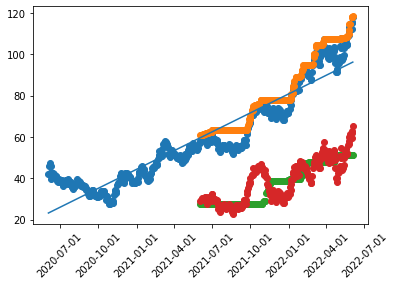

PBF
supply trend: nan


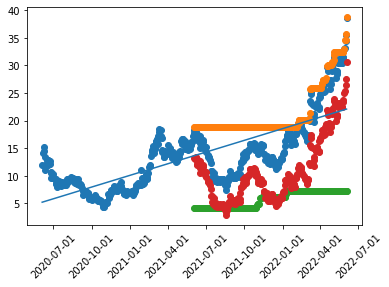

TALO
supply trend: nan


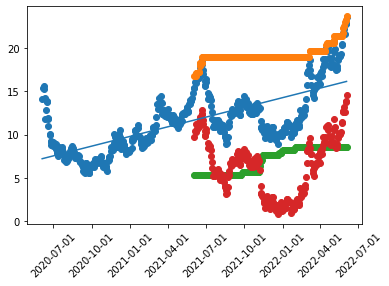

In [56]:
for s in screened_final_set:
    print(s)
    subset=prices[prices['Symbol']==s]
    
    dates = []
    for t in subset['Date'].values:
        d = pd.Timestamp(t).strftime('%Y-%m-%d')
        dates.append(d)
        dto = datetime.strptime(d, '%Y-%m-%d').date()

    old_ordinal = [datetime.strptime(i, '%Y-%m-%d').toordinal() for i in dates]
    new_ordinal = old_ordinal + md.date2num(np.datetime64('0000-12-31'))
    x = new_ordinal
    y= subset['Adj Close']

    slope, intercept, r, p, std_err = stats.linregress(x, y)

    mymodel = list(map(myfunc, x))

    fig, ax = plt.subplots()
    
    plt.scatter(x, y)
    plt.scatter(x, subset['trailing_1yr_max'])
    plt.scatter(x, subset['trailing_1yr_min'])
    
    plt.scatter(x, subset['supply_trend'])
    print("supply trend:",screener.loc[np.where(screener.set_index('Symbol').index==s)[0][0]]['vol_30d_2yr'])

    plt.plot(x, mymodel)
    
    l = matplotlib.dates.AutoDateLocator()
    f = matplotlib.dates.ConciseDateFormatter(l)    
    
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    
    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    date_form = DateFormatter("%Y-%m-%d")
    ax.xaxis.set_major_formatter(date_form)
    plt.show()